In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 196 (delta 90), reused 182 (delta 83), pack-reused 0
Receiving objects: 100% (196/196), 64.83 MiB | 30.61 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Updating files: 100% (84/84), done.


---

In [ ]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/UTD-MHAD'

In [ ]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import UTDReader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-2-39c06dafd6f8>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [ ]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    
    "sem-space": 'attr',
    # model training configs
    "model_params":{
        "linear_filters":[512,1024,1024,256],
        "input_feat":36,
        "dropout":0.1,
    },
    "include_attribute_loss": True, 
    "n_actions": 18,
    "folding": True,
    "lr": 0.001,
    "ae_lr": 0.0001,
    "imu_lr": 0.0004,
    "ae_alpha": 0.9,
    "imu_alpha": 0.0001,
    "n_epochs": 35,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 64,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.9
}

In [ ]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [ ]:
IMU_data_path = data_root+'/IMU/'
dataReader = UTDReader(IMU_data_path)
actionList = dataReader.idToLabel

/content/src/datasets/data.py:490: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), np.array(labels, dtype=int), np.array(subjects)


In [ ]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [ ]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [ ]:
label_map = {'a1': 'swipe left', 'a2': 'swipe right', 'a3': 'wave', 'a4': 'clap', 'a5': 'throw', 'a6': 'arm cross', 'a7': 'basketball shoot', 'a8': 'draw x', 'a9': 'draw circle(clockwise)', 'a10': 'draw circle(counter clockwise)', 'a11': 'draw triangle', 'a12': 'bowling', 'a13': 'boxing', 'a14': 'baseball swing', 'a15': 'tennis swing', 'a16': 'arm curl', 'a17': 'tennis serve', 'a18': 'push', 'a19': 'knock', 'a20': 'catch', 'a21': 'pickup & throw', 'a22': 'jog', 'a23': 'walk', 'a24': 'sit to stand', 'a25': 'stand to sit', 'a26': 'lunge', 'a27': 'squat',}
video_classes = [label_map[a] for a in video_classes]

In [ ]:
video_feat.shape

(27, 400)

In [ ]:
vid_cls_name = np.unique(video_classes)
vid_cls_name

array(['arm cross', 'arm curl', 'baseball swing', 'basketball shoot',
       'bowling', 'boxing', 'catch', 'clap', 'draw circle(clockwise)',
       'draw circle(counter clockwise)', 'draw triangle', 'draw x', 'jog',
       'knock', 'lunge', 'pickup & throw', 'push', 'sit to stand',
       'squat', 'stand to sit', 'swipe left', 'swipe right',
       'tennis serve', 'tennis swing', 'throw', 'walk', 'wave'],
      dtype='<U30')

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [ ]:
class SOTAEmbedding(nn.Module):
    def __init__(self, linear_filters=[1024,1024,1024,2048],input_feat=36, dropout=0.1):
        super(SOTAEmbedding, self).__init__()
        self.input_feat = input_feat
        self.linear_filters = linear_filters
        self.input_feat = input_feat
        self.dropout = dropout

        self.linear1 = nn.Linear(input_feat,linear_filters[0])
        self.batch_norm1 = nn.BatchNorm1d(linear_filters[0])
        self.linear2 = nn.Linear(linear_filters[0],linear_filters[1])
        self.batch_norm2 = nn.BatchNorm1d(linear_filters[1])
        self.linear3 = nn.Linear(linear_filters[1],linear_filters[2])
        self.batch_norm3 = nn.BatchNorm1d(linear_filters[2])
        self.linear4 = nn.Linear(linear_filters[2]+linear_filters[1]+linear_filters[0],linear_filters[3])
        self.batch_norm4 = nn.BatchNorm1d(linear_filters[3])
        self.act = F.relu



    def forward(self, x):
        #layer1
        out1 = self.linear1(x)
        out1 = self.batch_norm1(out1)
        out1 = self.act(out1)

        #layer2
        out2 = self.linear2(out1)
        out2 = self.batch_norm2(out2)
        out2 = self.act(out2)

        #layer3
        out3 = self.linear3(out2)
        out3 = self.batch_norm3(out3)
        out3 = self.act(out3)

        concat = torch.cat([out1,out2,out3],-1)

        #layer4
        out4 = self.linear4(concat)
        out4 = self.batch_norm4(out4)
        out4 = self.act(out4)
        return out4

In [ ]:
model = SOTAEmbedding(
    linear_filters=config["model_params"]["linear_filters"],
    input_feat=config["model_params"]["input_feat"],
    dropout=config["model_params"]["dropout"]
)

emb = model(torch.randn((32,36)))
emb.size()

torch.Size([32, 128])

---

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# run 5-fold running
fold_classes = [['swipe left', 'arm cross', 'draw triangle', 'arm curl', 'jog', 'pickup & throw'], ['swipe right', 'basketball shoot', 'bowling', 'tennis serve', 'walk', 'squat'], ['wave', 'draw x', 'boxing', 'push', 'sit to stand'], ['clap', 'draw circle(clockwise)', 'baseball swing', 'knock', 'stand to sit'], ['throw', 'draw circle(counter clockwise)', 'tennis swing', 'catch', 'lunge']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [ ]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [ ]:
dataReader.label_map

[(1, 'swipe left'),
 (2, 'swipe right'),
 (3, 'wave'),
 (4, 'clap'),
 (5, 'throw'),
 (6, 'arm cross'),
 (7, 'basketball shoot'),
 (8, 'draw x'),
 (9, 'draw circle(clockwise)'),
 (10, 'draw circle(counter clockwise)'),
 (11, 'draw triangle'),
 (12, 'bowling'),
 (13, 'boxing'),
 (14, 'baseball swing'),
 (15, 'tennis swing'),
 (16, 'arm curl'),
 (17, 'tennis serve'),
 (18, 'push'),
 (19, 'knock'),
 (20, 'catch'),
 (21, 'pickup & throw'),
 (22, 'jog'),
 (23, 'walk'),
 (24, 'sit to stand'),
 (25, 'stand to sit'),
 (26, 'lunge'),
 (27, 'squat')]

In [ ]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [ ]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.1, unseen_ratio=0.8, window_size=12, window_overlap=10, resample_freq=50,)

data shape : (861,), seen_data shape : (669,)
{'swipe left': 32, 'swipe right': 32, 'wave': 32, 'clap': 32, 'throw': 32, 'arm cross': 32, 'basketball shoot': 32, 'draw x': 31, 'draw circle(clockwise)': 32, 'draw circle(counter clockwise)': 32, 'draw triangle': 32, 'bowling': 32, 'boxing': 32, 'baseball swing': 32, 'tennis swing': 32, 'arm curl': 32, 'tennis serve': 32, 'push': 32, 'knock': 32, 'catch': 32, 'pickup & throw': 32, 'jog': 32, 'walk': 31, 'sit to stand': 32, 'stand to sit': 32, 'lunge': 32, 'squat': 31}
(1789, 50, 6)


In [ ]:
data_dict['train']['X'].shape,data_dict['eval-seen']['X'].shape,data_dict["test"]["X"].shape

((1610, 50, 6), (179, 50, 6), (536, 50, 6))

In [ ]:
def loss_cross_entropy(
        y_pred:torch.Tensor,
        cls:torch.Tensor,
        selected_features,
        loss_fn=nn.CrossEntropyLoss(reduction="mean")
):
    num_classes = selected_features.size()[0]
    #print(selected_features)
    # print("selected featues > ", selected_features.shape, "y_pred > ", y_pred.shape)
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        #print(entry.repeat(num_classes,1),selected_features.size())
        cosine_sim = F.softmax(F.cosine_similarity(entry.repeat(num_classes,1),selected_features),dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,cls)
    #print(loss)
    return loss

def loss_reconstruction_calc(y_pred:torch.Tensor,y_feat:torch.Tensor,loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    #print(loss)
    return loss

def predict_class(
        y_pred:torch.Tensor,
        selected_features):

    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [ ]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [ ]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            # convert feature vector into action class
            # using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    metrics_dict.update(metrics)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

================ Fold-0 ================
Unseen Classes : ['swipe left', 'arm cross', 'draw triangle', 'arm curl', 'jog', 'pickup & throw']
data shape : (861,), seen_data shape : (669,)
{'swipe left': 32, 'swipe right': 32, 'wave': 32, 'clap': 32, 'throw': 32, 'arm cross': 32, 'basketball shoot': 32, 'draw x': 31, 'draw circle(clockwise)': 32, 'draw circle(counter clockwise)': 32, 'draw triangle': 32, 'bowling': 32, 'boxing': 32, 'baseball swing': 32, 'tennis swing': 32, 'arm curl': 32, 'tennis serve': 32, 'push': 32, 'knock': 32, 'catch': 32, 'pickup & throw': 32, 'jog': 32, 'walk': 31, 'sit to stand': 32, 'stand to sit': 32, 'lunge': 32, 'squat': 31}
(1789, 50, 6)
seen classes >  [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 22, 23, 24, 25, 26]
unseen classes >  [0, 5, 10, 15, 21, 20]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

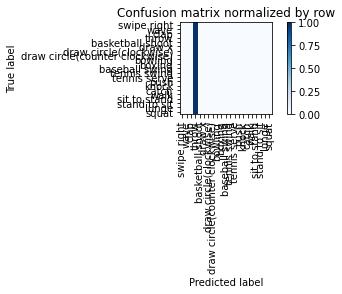

Overall accuracy: 0.025



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

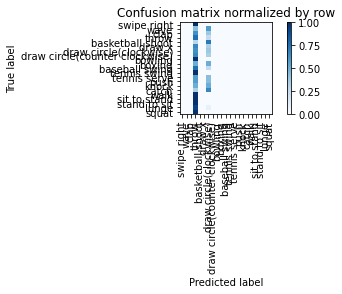

Overall accuracy: 0.037



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

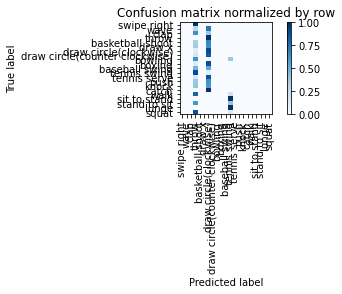

Overall accuracy: 0.050



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

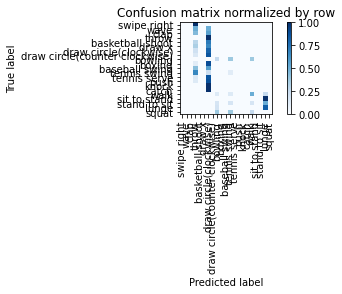

Overall accuracy: 0.150



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

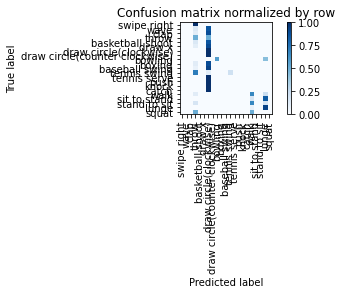

Overall accuracy: 0.219



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

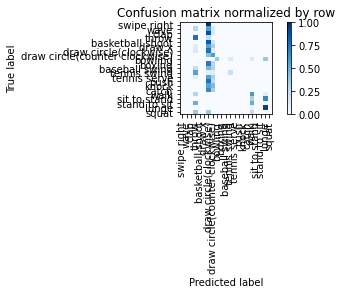

Overall accuracy: 0.231



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

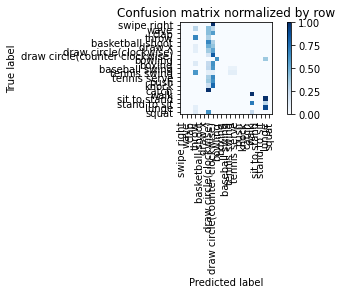

Overall accuracy: 0.231



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

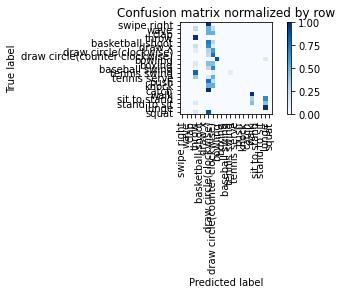

Overall accuracy: 0.237



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

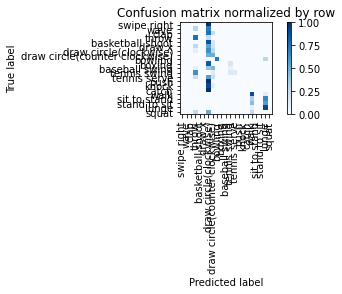

Overall accuracy: 0.231



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

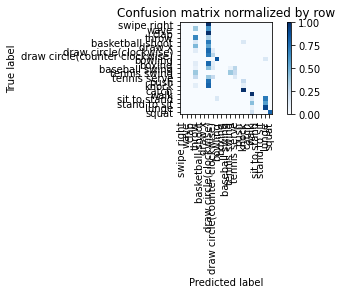

Overall accuracy: 0.281



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

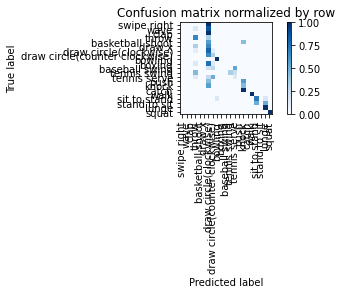

Overall accuracy: 0.388



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

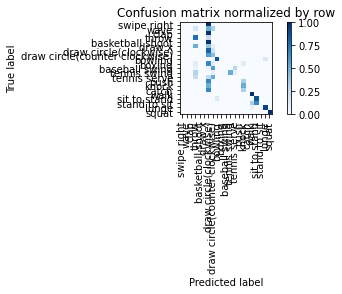

Overall accuracy: 0.388



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

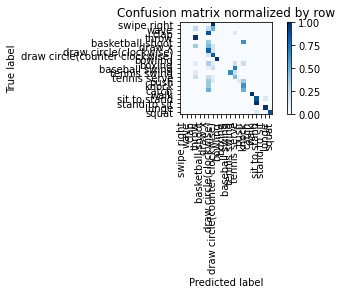

Overall accuracy: 0.438



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

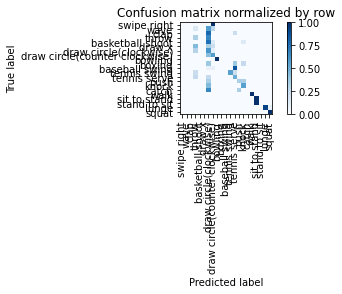

Overall accuracy: 0.425



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

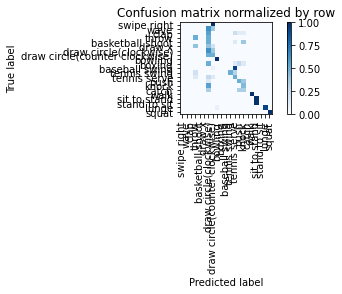

Overall accuracy: 0.419



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

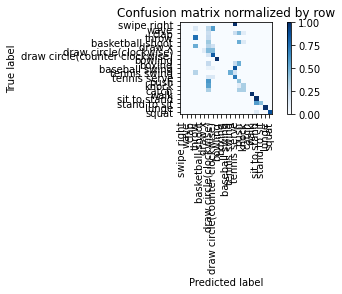

Overall accuracy: 0.444



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

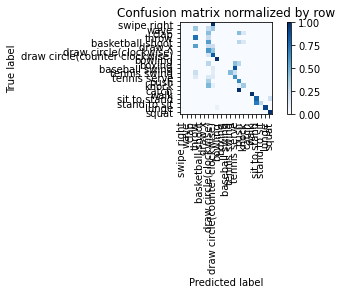

Overall accuracy: 0.463



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

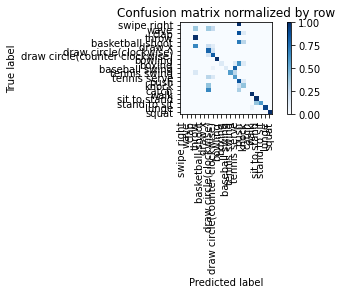

Overall accuracy: 0.525



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

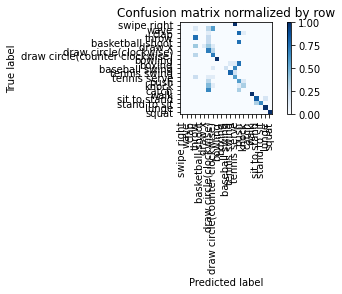

Overall accuracy: 0.506



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

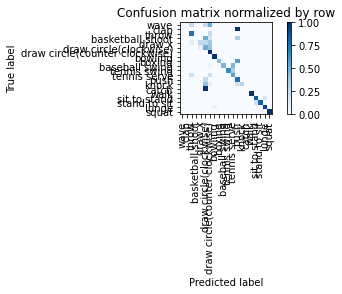

Overall accuracy: 0.562



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

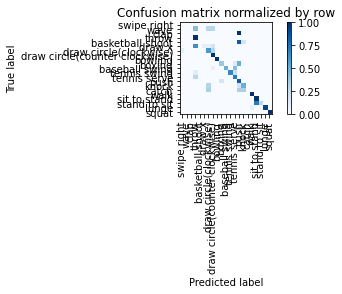

Overall accuracy: 0.581



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

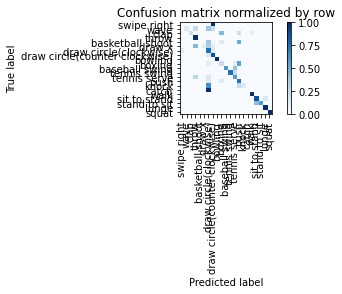

Overall accuracy: 0.575



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

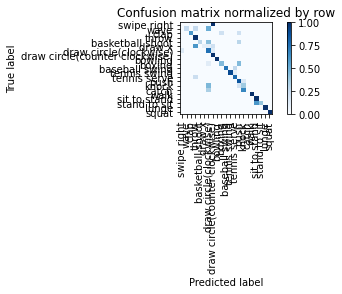

Overall accuracy: 0.681



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

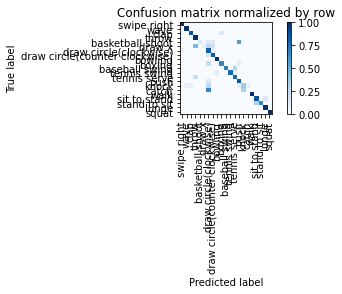

Overall accuracy: 0.719



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

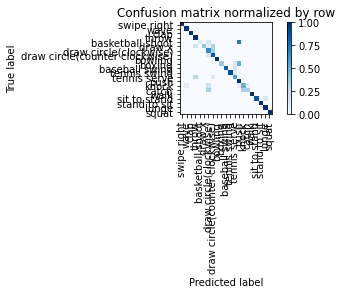

Overall accuracy: 0.775



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

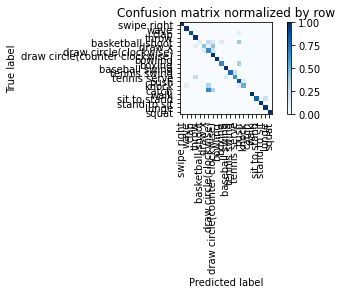

Overall accuracy: 0.787



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

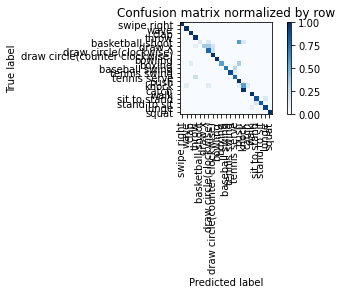

Overall accuracy: 0.775



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

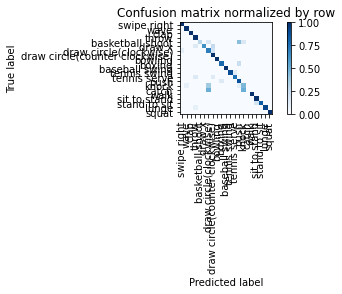

Overall accuracy: 0.831



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

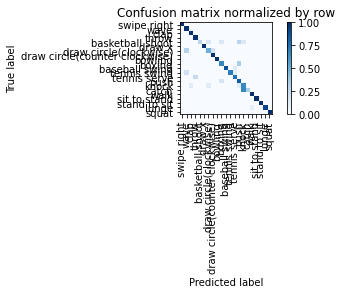

Overall accuracy: 0.831



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

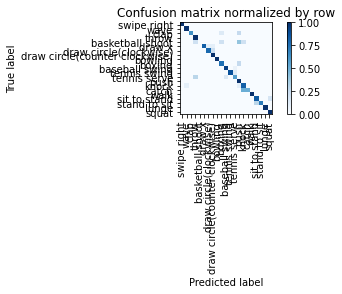

Overall accuracy: 0.844



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

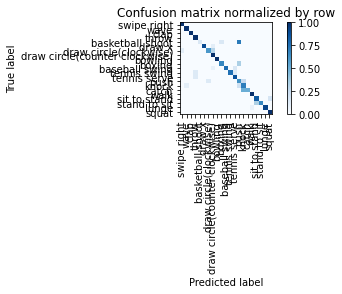

Overall accuracy: 0.806



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

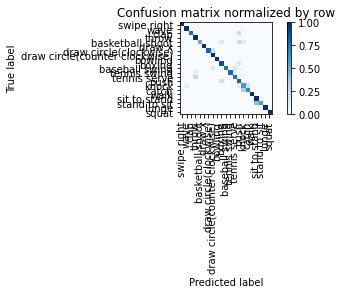

Overall accuracy: 0.838



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

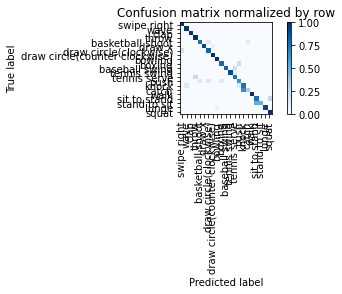

Overall accuracy: 0.850



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

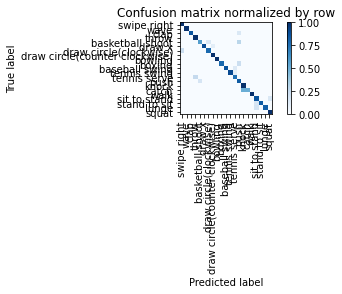

Overall accuracy: 0.875



train:   0%|          | 0/50 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

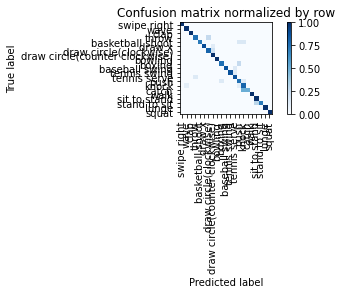

Overall accuracy: 0.881



unseen:   0%|          | 0/16 [00:00<?, ?batch/s]

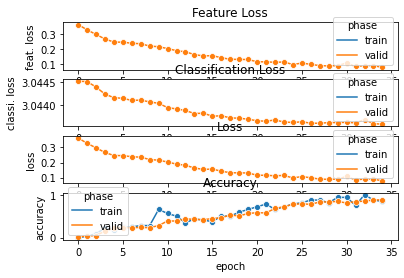

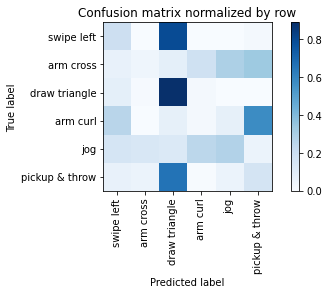

Overall accuracy: 0.303

{'accuracy': 0.302734375, 'precision': 0.22954211618112508, 'recall': 0.2623314962152506, 'f1': 0.21998604805933034, 'samples': 512, 'loss': 156.96924924850464, 'feat. loss': 156.8775224685669, 'classi. loss': 917.2808036804199}
================ Fold-1 ================
Unseen Classes : ['swipe right', 'basketball shoot', 'bowling', 'tennis serve', 'walk', 'squat']
data shape : (861,), seen_data shape : (671,)
{'swipe left': 32, 'swipe right': 32, 'wave': 32, 'clap': 32, 'throw': 32, 'arm cross': 32, 'basketball shoot': 32, 'draw x': 31, 'draw circle(clockwise)': 32, 'draw circle(counter clockwise)': 32, 'draw triangle': 32, 'bowling': 32, 'boxing': 32, 'baseball swing': 32, 'tennis swing': 32, 'arm curl': 32, 'tennis serve': 32, 'push': 32, 'knock': 32, 'catch': 32, 'pickup & throw': 32, 'jog': 32, 'walk': 31, 'sit to stand': 32, 'stand to sit': 32, 'lunge': 32, 'squat': 31}
(1752, 50, 6)
seen classes >  [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 

Training Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

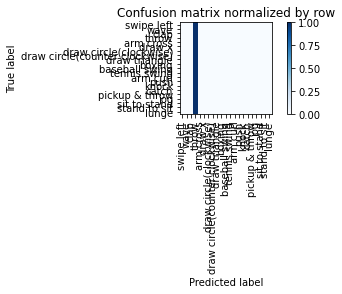

Overall accuracy: 0.056



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

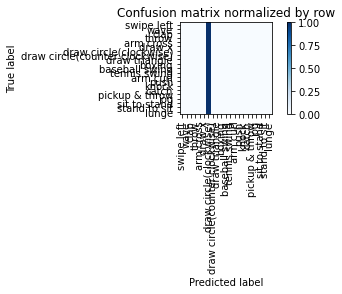

Overall accuracy: 0.050



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

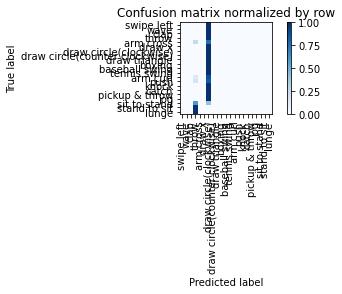

Overall accuracy: 0.044



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

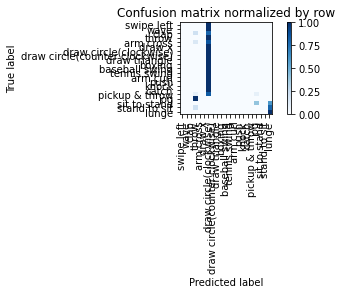

Overall accuracy: 0.106



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

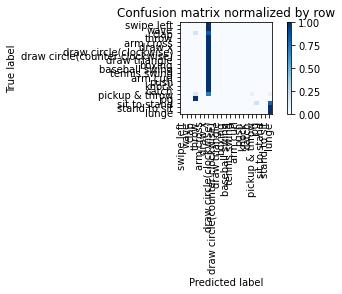

Overall accuracy: 0.094



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

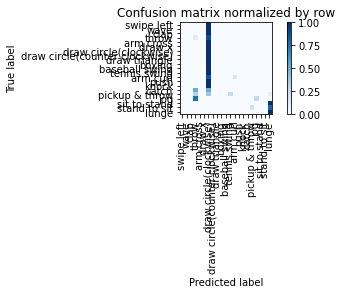

Overall accuracy: 0.119



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

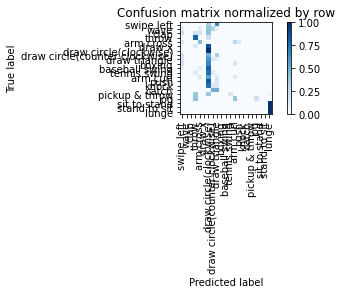

Overall accuracy: 0.200



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

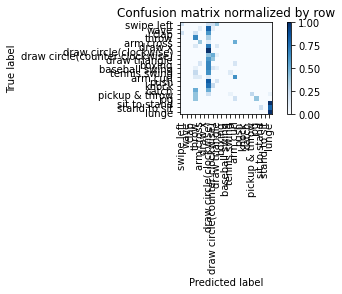

Overall accuracy: 0.269



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

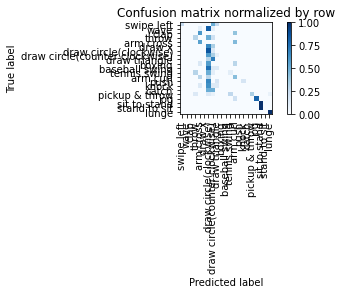

Overall accuracy: 0.281



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

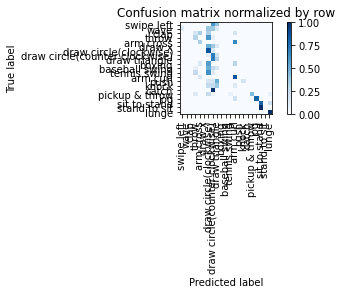

Overall accuracy: 0.319



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

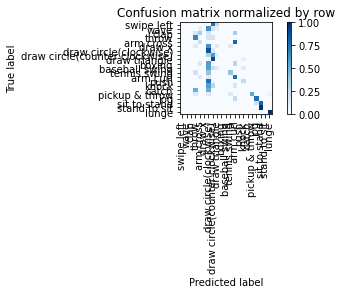

Overall accuracy: 0.331



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

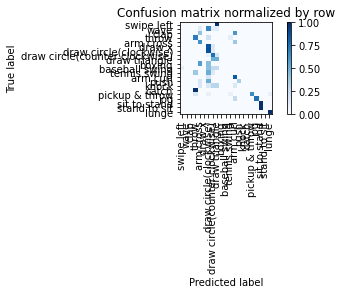

Overall accuracy: 0.425



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

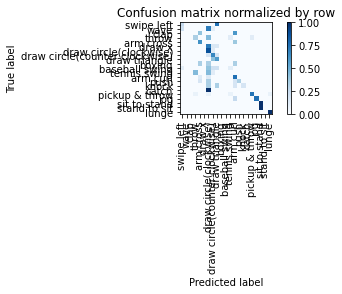

Overall accuracy: 0.425



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

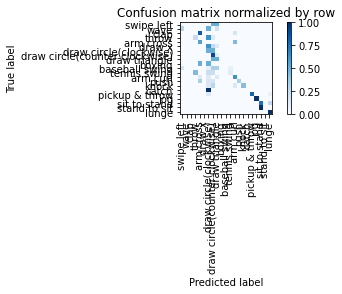

Overall accuracy: 0.406



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

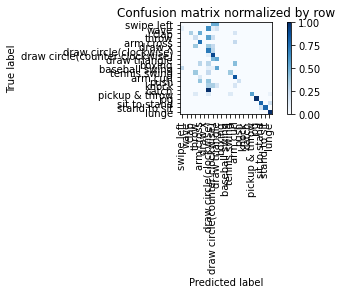

Overall accuracy: 0.444



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

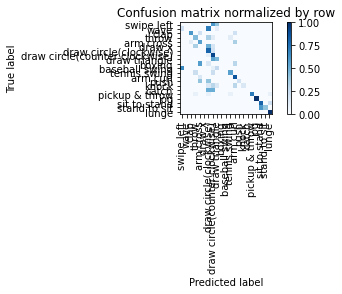

Overall accuracy: 0.475



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

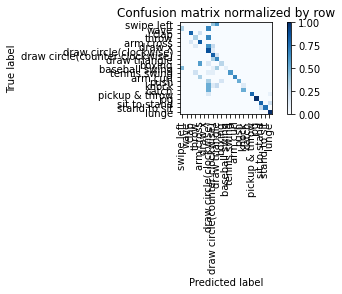

Overall accuracy: 0.531



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

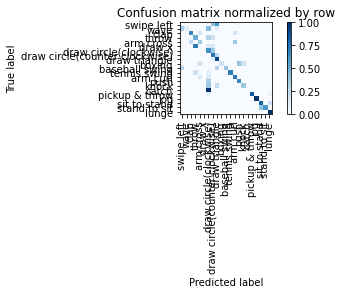

Overall accuracy: 0.581



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

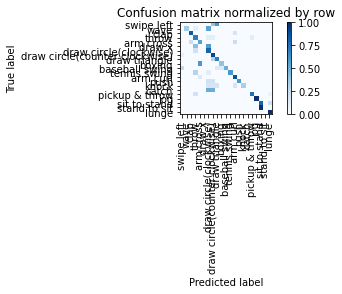

Overall accuracy: 0.613



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

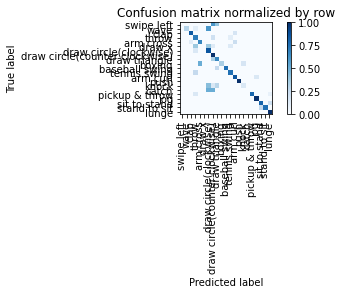

Overall accuracy: 0.656



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

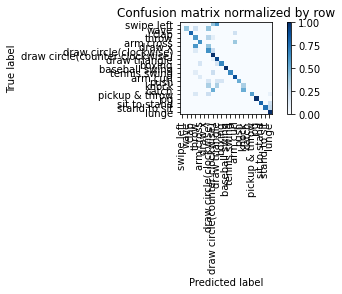

Overall accuracy: 0.681



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

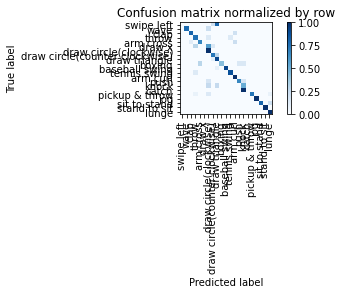

Overall accuracy: 0.731



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

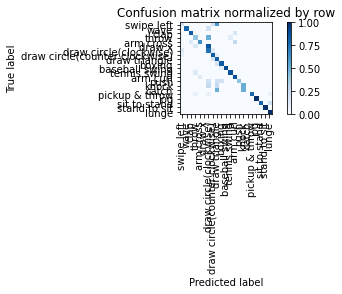

Overall accuracy: 0.713



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

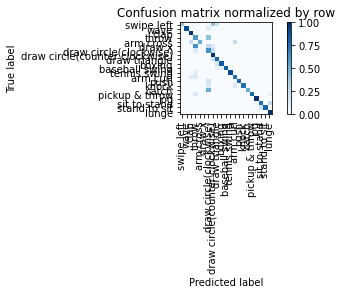

Overall accuracy: 0.750



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

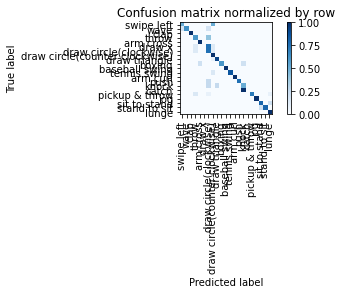

Overall accuracy: 0.769



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

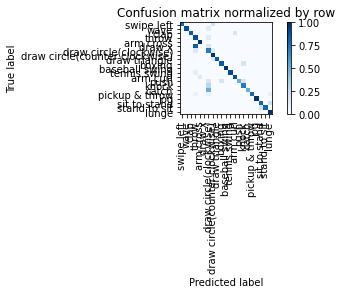

Overall accuracy: 0.825



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

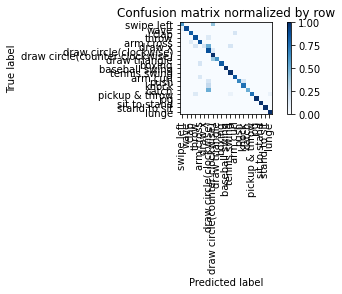

Overall accuracy: 0.825



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

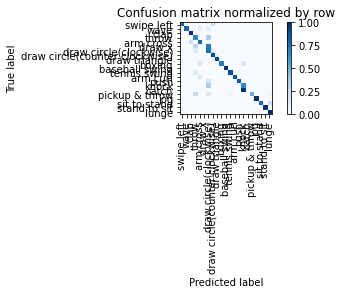

Overall accuracy: 0.781



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

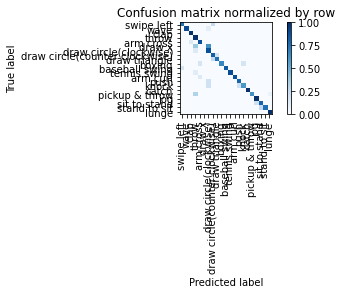

Overall accuracy: 0.787



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

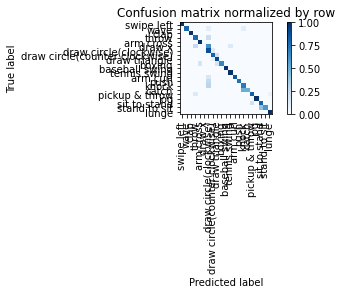

Overall accuracy: 0.819



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

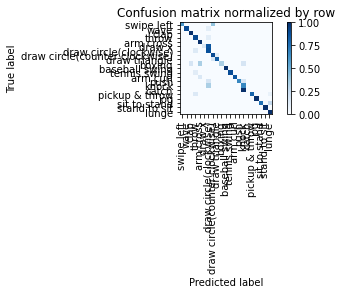

Overall accuracy: 0.819



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

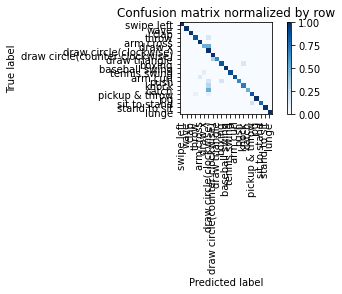

Overall accuracy: 0.875



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

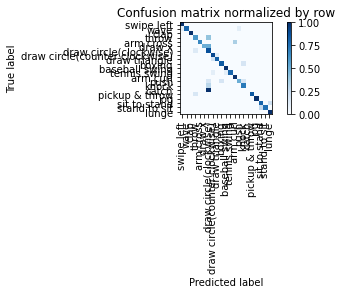

Overall accuracy: 0.812



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

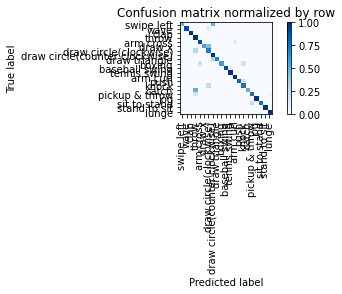

Overall accuracy: 0.844



train:   0%|          | 0/49 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

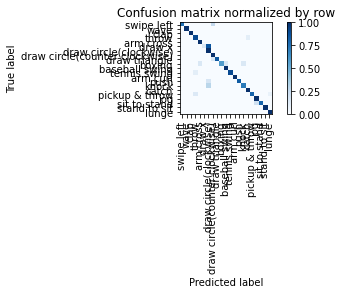

Overall accuracy: 0.869



unseen:   0%|          | 0/17 [00:00<?, ?batch/s]

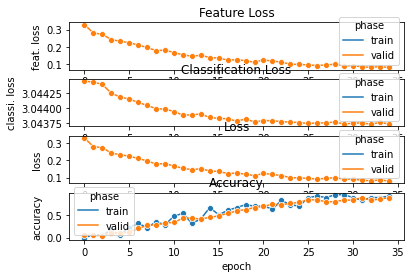

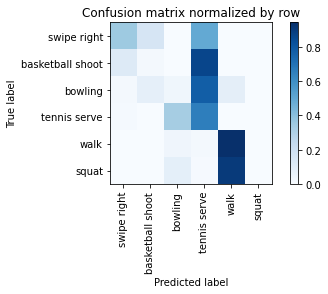

Overall accuracy: 0.325

{'accuracy': 0.32536764705882354, 'precision': 0.24460843021873258, 'recall': 0.33405914734429193, 'f1': 0.2480493149488012, 'samples': 544, 'loss': 227.81457901000977, 'feat. loss': 227.71712589263916, 'classi. loss': 974.5395278930664}
================ Fold-2 ================
Unseen Classes : ['wave', 'draw x', 'boxing', 'push', 'sit to stand']
data shape : (861,), seen_data shape : (702,)
{'swipe left': 32, 'swipe right': 32, 'wave': 32, 'clap': 32, 'throw': 32, 'arm cross': 32, 'basketball shoot': 32, 'draw x': 31, 'draw circle(clockwise)': 32, 'draw circle(counter clockwise)': 32, 'draw triangle': 32, 'bowling': 32, 'boxing': 32, 'baseball swing': 32, 'tennis swing': 32, 'arm curl': 32, 'tennis serve': 32, 'push': 32, 'knock': 32, 'catch': 32, 'pickup & throw': 32, 'jog': 32, 'walk': 31, 'sit to stand': 32, 'stand to sit': 32, 'lunge': 32, 'squat': 31}
(1973, 50, 6)
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25

Training Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

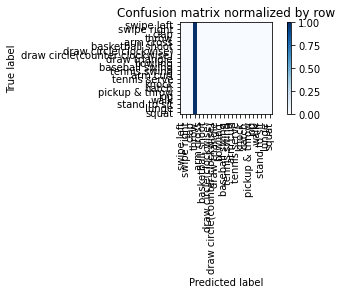

Overall accuracy: 0.031



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

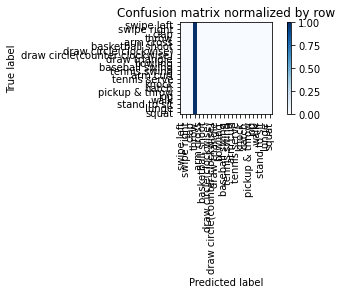

Overall accuracy: 0.031



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

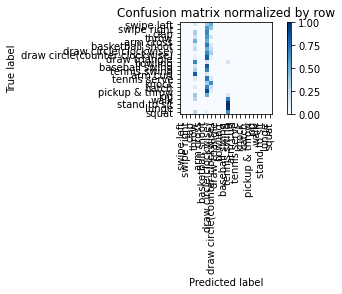

Overall accuracy: 0.042



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

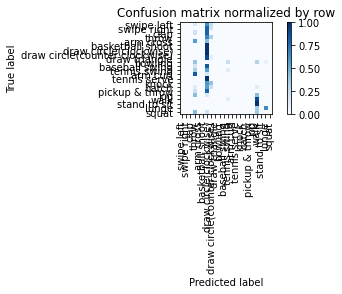

Overall accuracy: 0.151



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

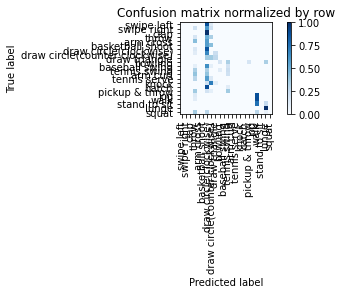

Overall accuracy: 0.203



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

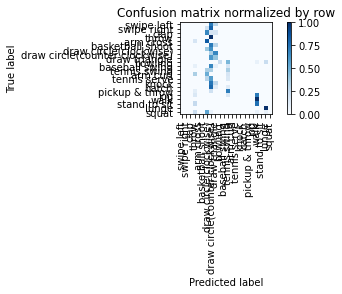

Overall accuracy: 0.224



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

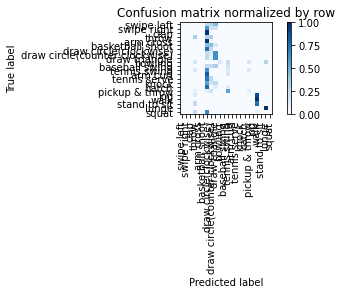

Overall accuracy: 0.245



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

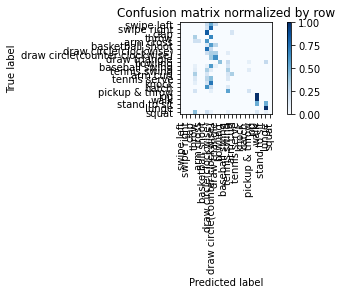

Overall accuracy: 0.297



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

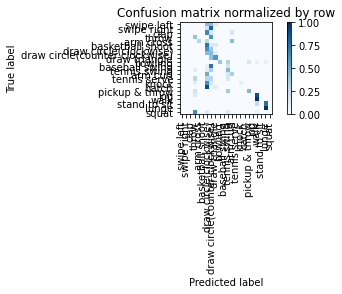

Overall accuracy: 0.318



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

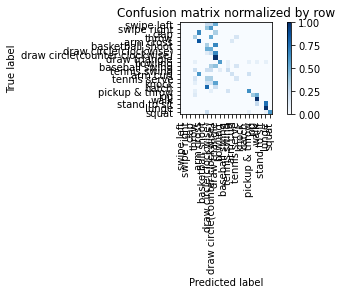

Overall accuracy: 0.417



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

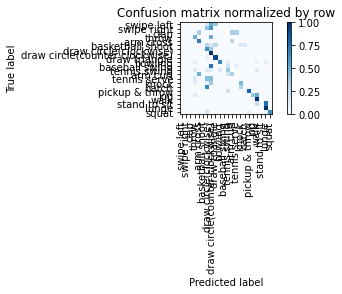

Overall accuracy: 0.495



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

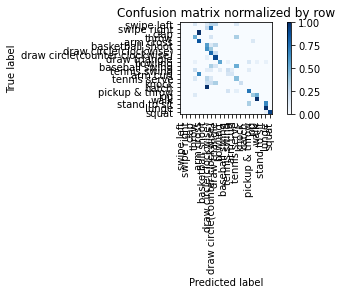

Overall accuracy: 0.505



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

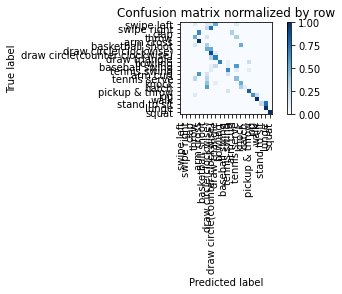

Overall accuracy: 0.562



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

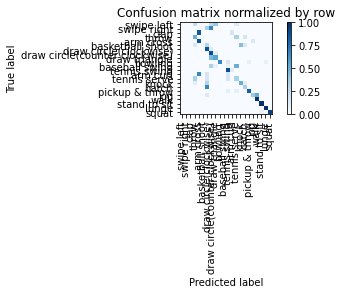

Overall accuracy: 0.578



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

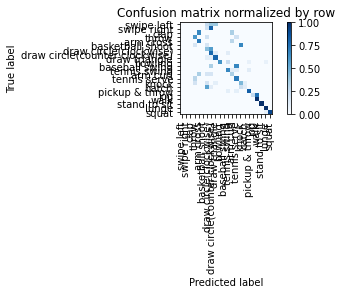

Overall accuracy: 0.552



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

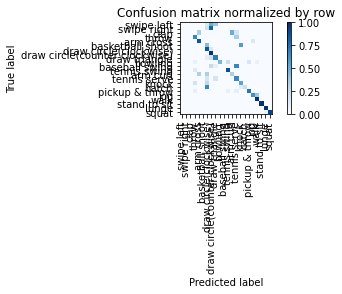

Overall accuracy: 0.594



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

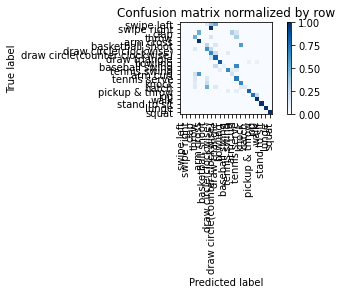

Overall accuracy: 0.620



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

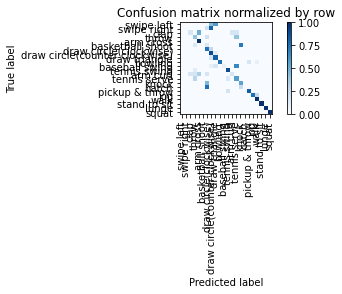

Overall accuracy: 0.625



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

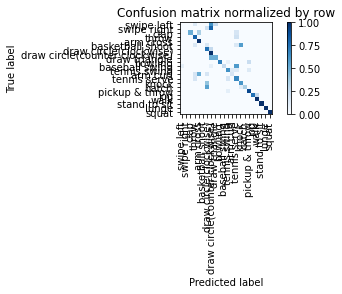

Overall accuracy: 0.651



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

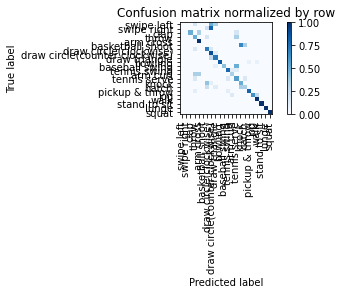

Overall accuracy: 0.672



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

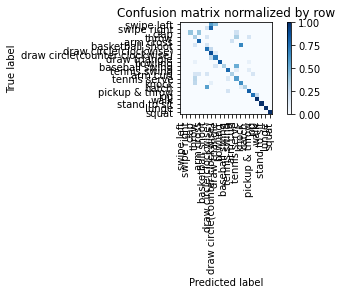

Overall accuracy: 0.661



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

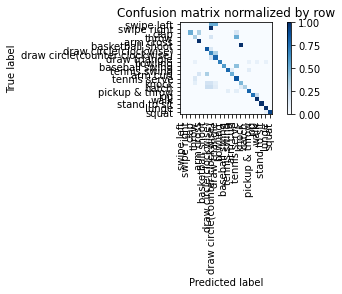

Overall accuracy: 0.667



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

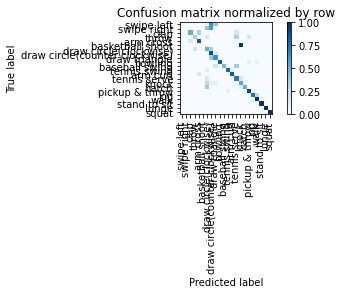

Overall accuracy: 0.682



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

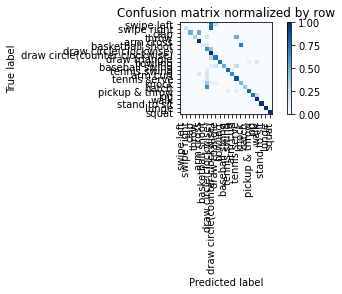

Overall accuracy: 0.688



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

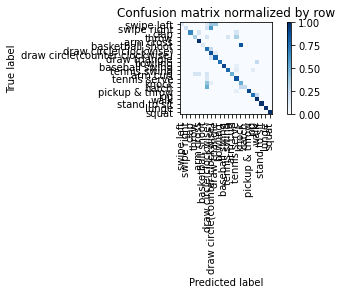

Overall accuracy: 0.729



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

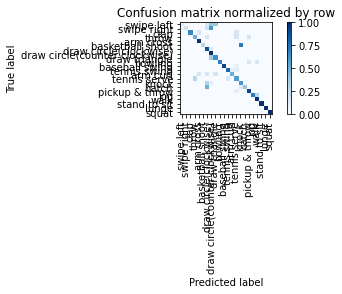

Overall accuracy: 0.734



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

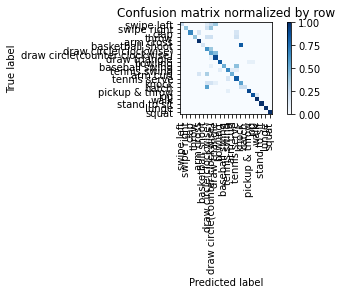

Overall accuracy: 0.708



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

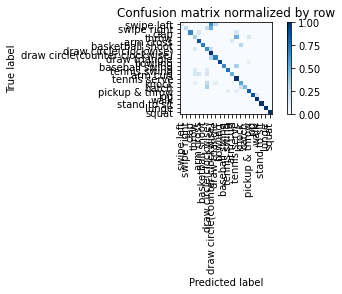

Overall accuracy: 0.750



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

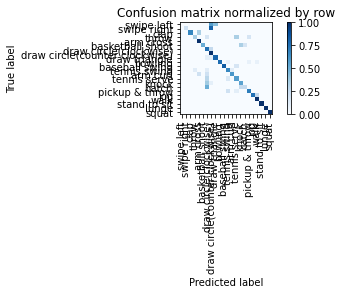

Overall accuracy: 0.724



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

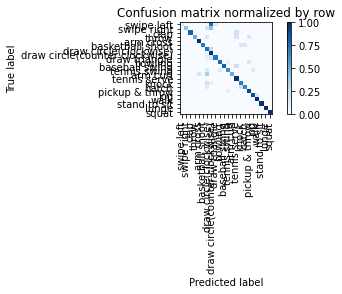

Overall accuracy: 0.792



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

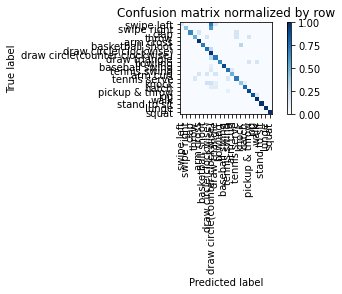

Overall accuracy: 0.776



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

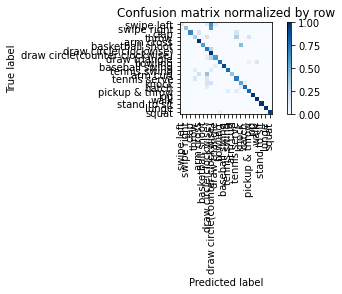

Overall accuracy: 0.760



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

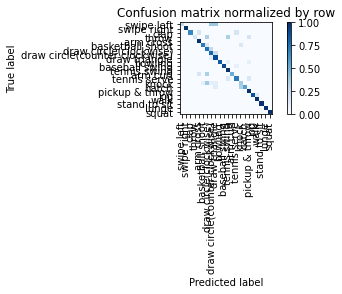

Overall accuracy: 0.792



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

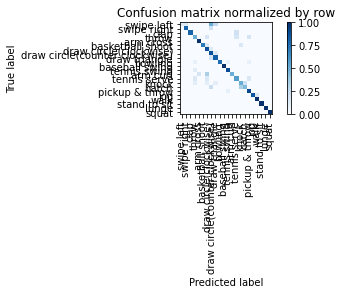

Overall accuracy: 0.792



train:   0%|          | 0/55 [00:00<?, ?batch/s]

seen:   0%|          | 0/6 [00:00<?, ?batch/s]

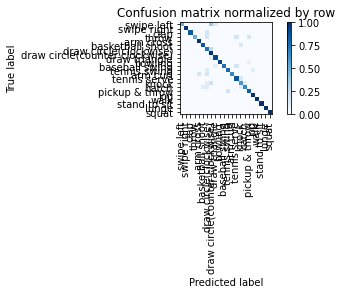

Overall accuracy: 0.844



unseen:   0%|          | 0/11 [00:00<?, ?batch/s]

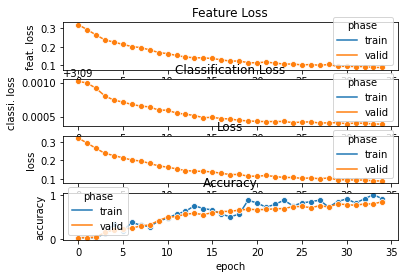

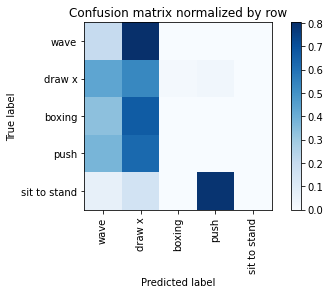

Overall accuracy: 0.165

{'accuracy': 0.16477272727272727, 'precision': 0.07115384615384615, 'recall': 0.14583528676355678, 'f1': 0.09313117996044826, 'samples': 352, 'loss': 128.0626745223999, 'feat. loss': 128.00604629516602, 'classi. loss': 566.2707633972168}
================ Fold-3 ================
Unseen Classes : ['clap', 'draw circle(clockwise)', 'baseball swing', 'knock', 'stand to sit']
data shape : (861,), seen_data shape : (701,)
{'swipe left': 32, 'swipe right': 32, 'wave': 32, 'clap': 32, 'throw': 32, 'arm cross': 32, 'basketball shoot': 32, 'draw x': 31, 'draw circle(clockwise)': 32, 'draw circle(counter clockwise)': 32, 'draw triangle': 32, 'bowling': 32, 'boxing': 32, 'baseball swing': 32, 'tennis swing': 32, 'arm curl': 32, 'tennis serve': 32, 'push': 32, 'knock': 32, 'catch': 32, 'pickup & throw': 32, 'jog': 32, 'walk': 31, 'sit to stand': 32, 'stand to sit': 32, 'lunge': 32, 'squat': 31}
(1899, 50, 6)
seen classes >  [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 1

Training Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

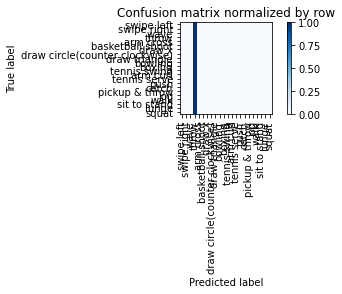

Overall accuracy: 0.056



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

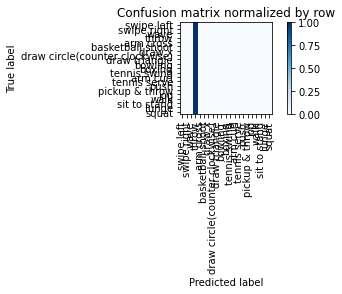

Overall accuracy: 0.050



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

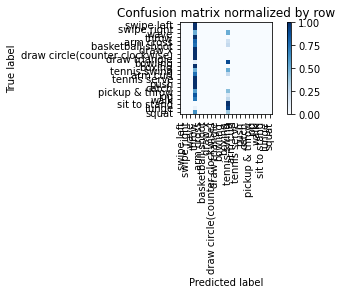

Overall accuracy: 0.069



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

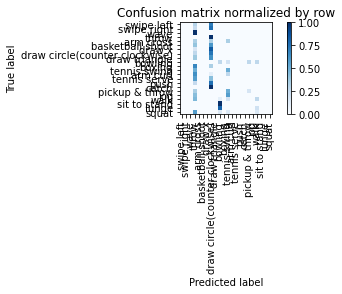

Overall accuracy: 0.113



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

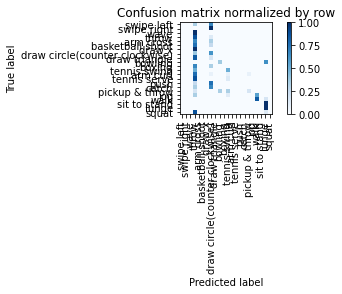

Overall accuracy: 0.287



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

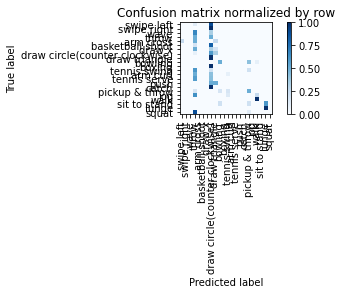

Overall accuracy: 0.281



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

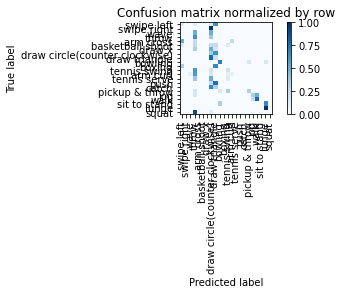

Overall accuracy: 0.319



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

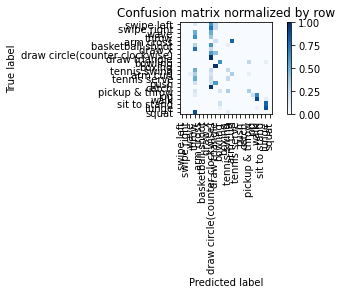

Overall accuracy: 0.319



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

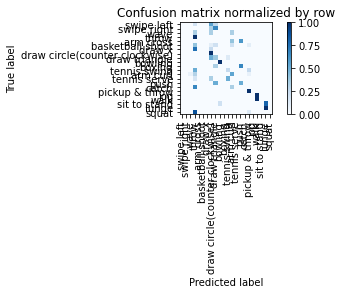

Overall accuracy: 0.469



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

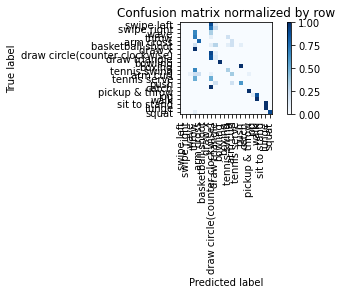

Overall accuracy: 0.500



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

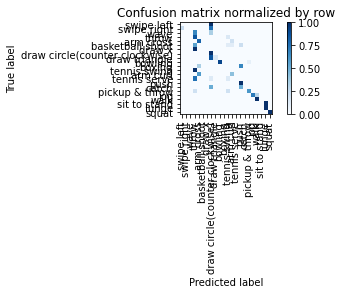

Overall accuracy: 0.550



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

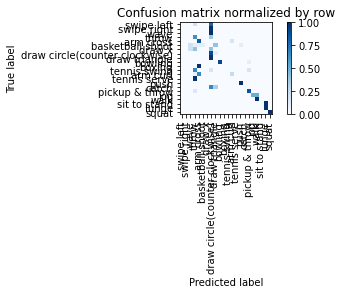

Overall accuracy: 0.512



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

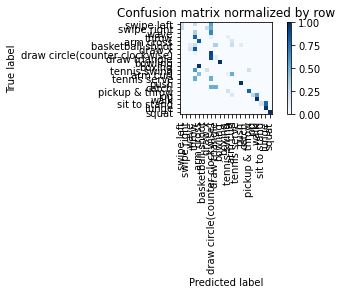

Overall accuracy: 0.550



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

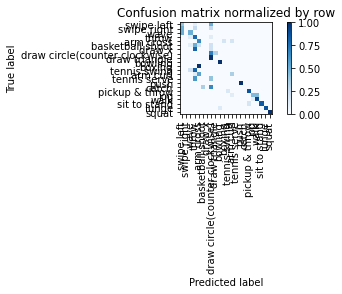

Overall accuracy: 0.531



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

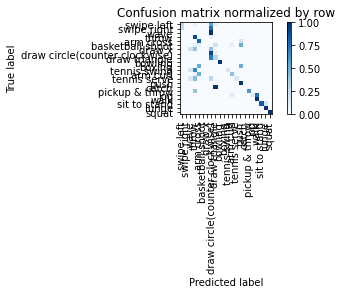

Overall accuracy: 0.569



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

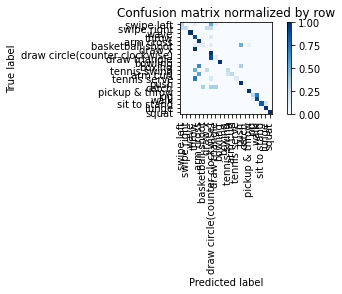

Overall accuracy: 0.606



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

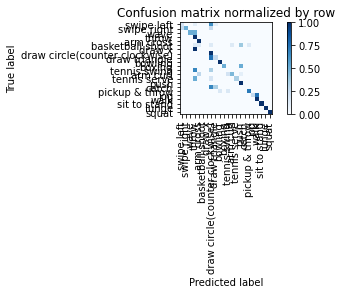

Overall accuracy: 0.644



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

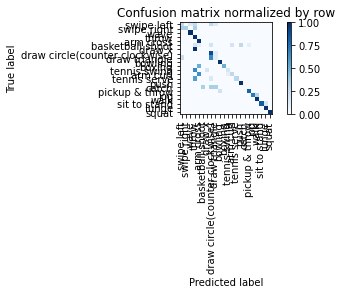

Overall accuracy: 0.637



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

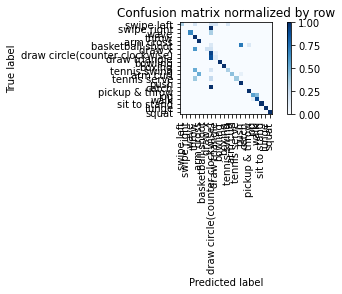

Overall accuracy: 0.700



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

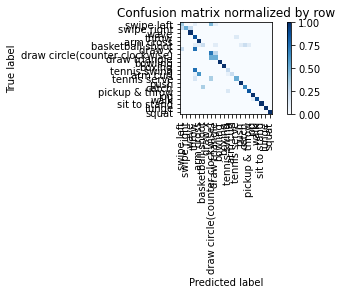

Overall accuracy: 0.706



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

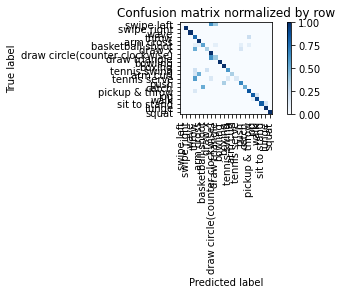

Overall accuracy: 0.713



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

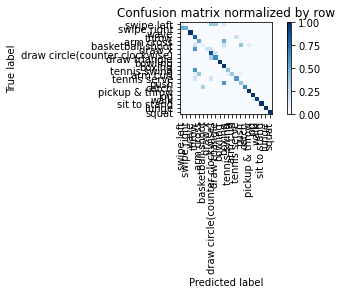

Overall accuracy: 0.700



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

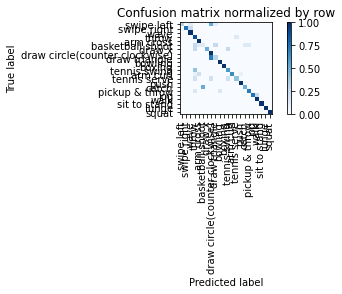

Overall accuracy: 0.762



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

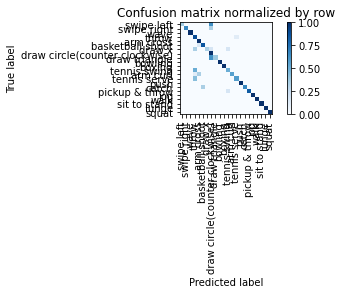

Overall accuracy: 0.812



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

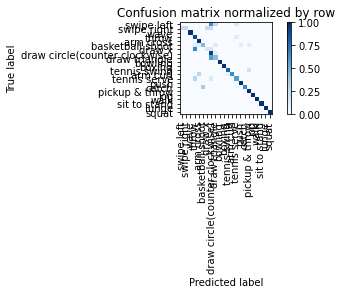

Overall accuracy: 0.769



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

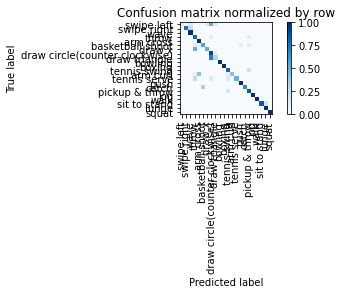

Overall accuracy: 0.762



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

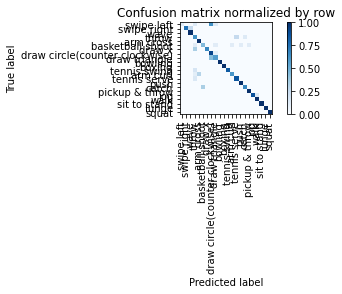

Overall accuracy: 0.812



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

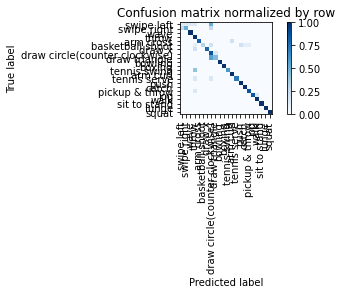

Overall accuracy: 0.806



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

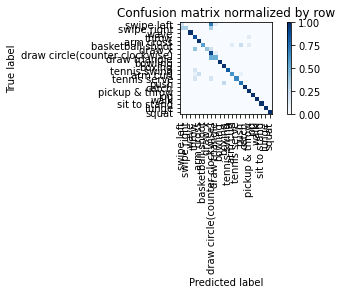

Overall accuracy: 0.800



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

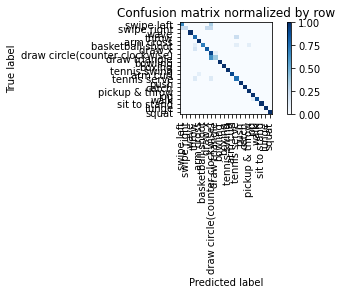

Overall accuracy: 0.863



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

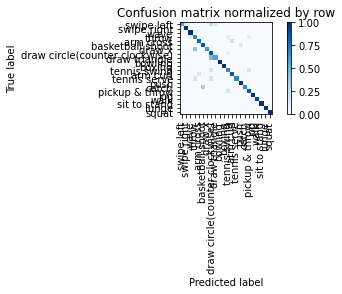

Overall accuracy: 0.838



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

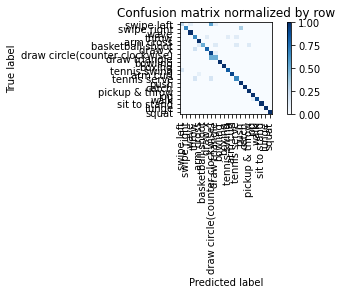

Overall accuracy: 0.838



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

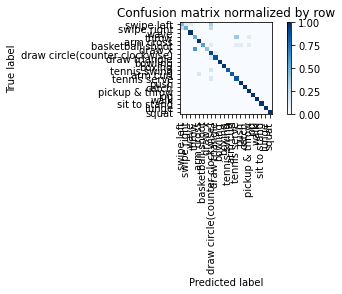

Overall accuracy: 0.850



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

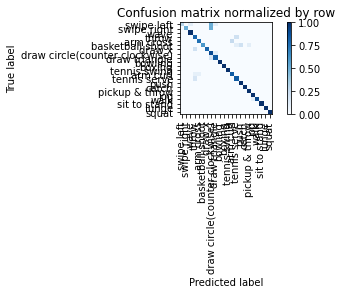

Overall accuracy: 0.856



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

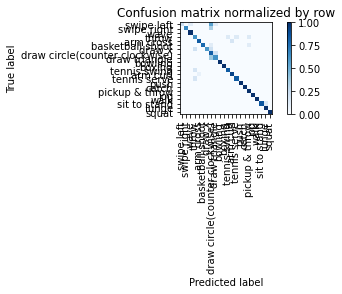

Overall accuracy: 0.844



unseen:   0%|          | 0/13 [00:00<?, ?batch/s]

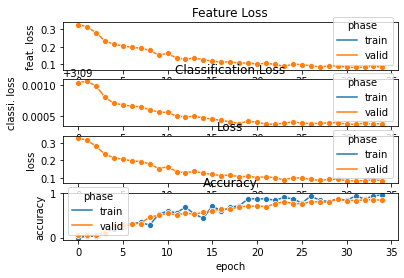

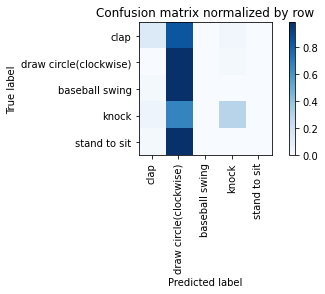

Overall accuracy: 0.334

{'accuracy': 0.33413461538461536, 'precision': 0.33546789225073403, 'recall': 0.28039110872728396, 'f1': 0.21738843014230652, 'samples': 416, 'loss': 142.82347106933594, 'feat. loss': 142.75657272338867, 'classi. loss': 668.9854011535645}
================ Fold-4 ================
Unseen Classes : ['throw', 'draw circle(counter clockwise)', 'tennis swing', 'catch', 'lunge']
data shape : (861,), seen_data shape : (701,)
{'swipe left': 32, 'swipe right': 32, 'wave': 32, 'clap': 32, 'throw': 32, 'arm cross': 32, 'basketball shoot': 32, 'draw x': 31, 'draw circle(clockwise)': 32, 'draw circle(counter clockwise)': 32, 'draw triangle': 32, 'bowling': 32, 'boxing': 32, 'baseball swing': 32, 'tennis swing': 32, 'arm curl': 32, 'tennis serve': 32, 'push': 32, 'knock': 32, 'catch': 32, 'pickup & throw': 32, 'jog': 32, 'walk': 31, 'sit to stand': 32, 'stand to sit': 32, 'lunge': 32, 'squat': 31}
(1887, 50, 6)
seen classes >  [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 

Training Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

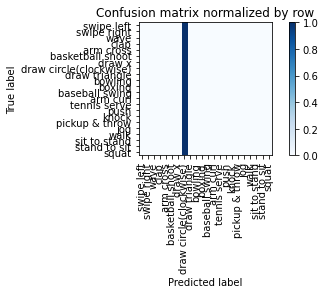

Overall accuracy: 0.069



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

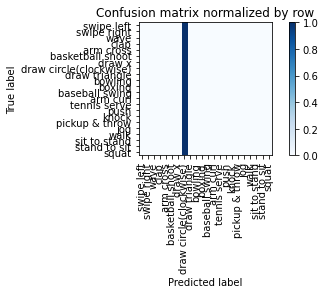

Overall accuracy: 0.056



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

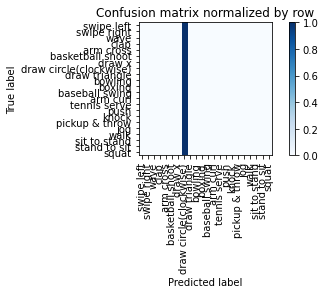

Overall accuracy: 0.069



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

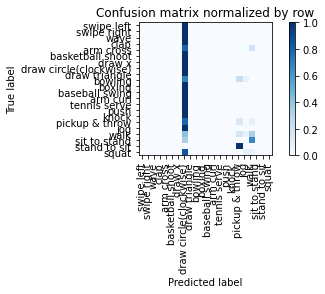

Overall accuracy: 0.100



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

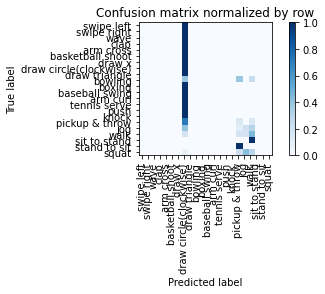

Overall accuracy: 0.119



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

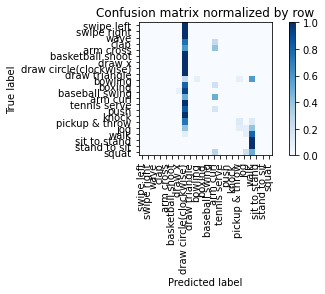

Overall accuracy: 0.163



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

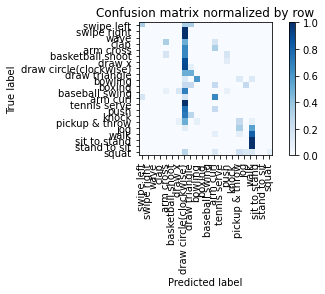

Overall accuracy: 0.244



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

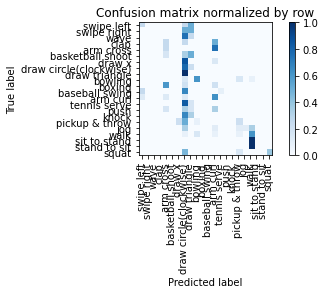

Overall accuracy: 0.244



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

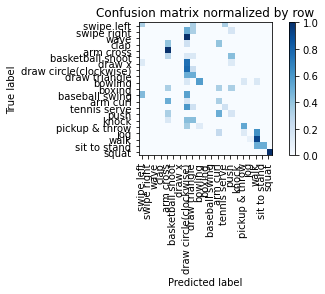

Overall accuracy: 0.400



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

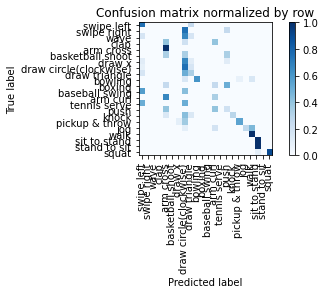

Overall accuracy: 0.406



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

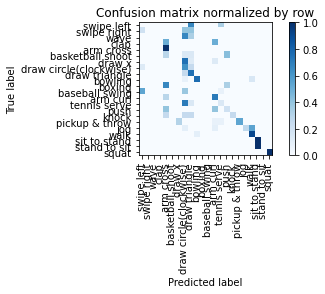

Overall accuracy: 0.425



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

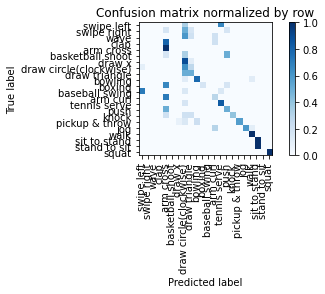

Overall accuracy: 0.475



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

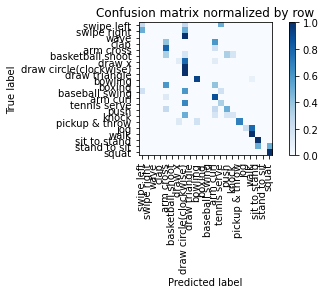

Overall accuracy: 0.500



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

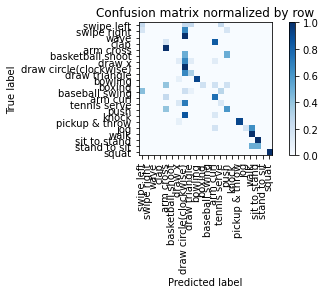

Overall accuracy: 0.481



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

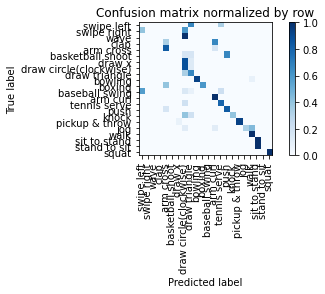

Overall accuracy: 0.581



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

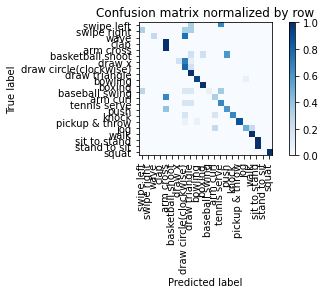

Overall accuracy: 0.619



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

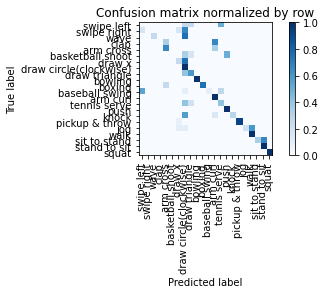

Overall accuracy: 0.594



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

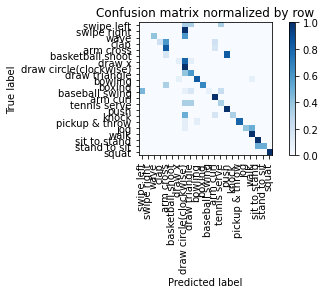

Overall accuracy: 0.594



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

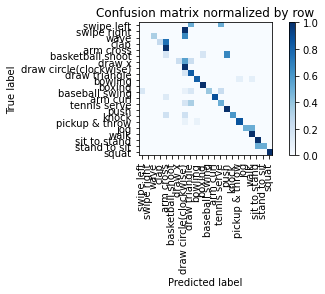

Overall accuracy: 0.681



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

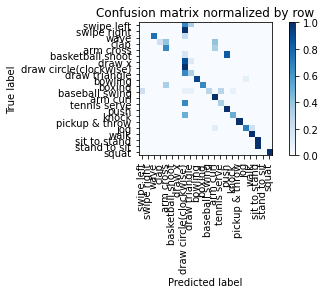

Overall accuracy: 0.644



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

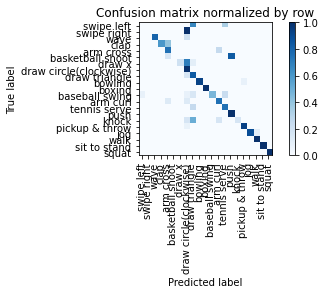

Overall accuracy: 0.725



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

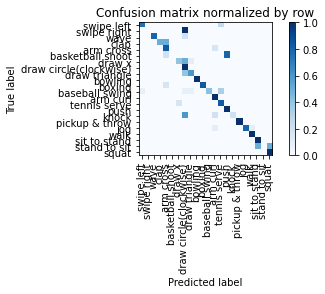

Overall accuracy: 0.762



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

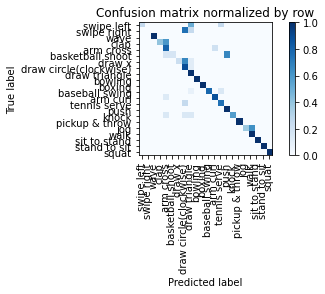

Overall accuracy: 0.769



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

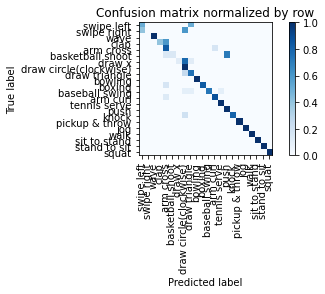

Overall accuracy: 0.806



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

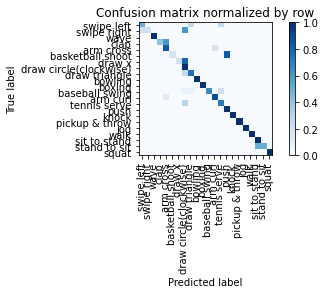

Overall accuracy: 0.794



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

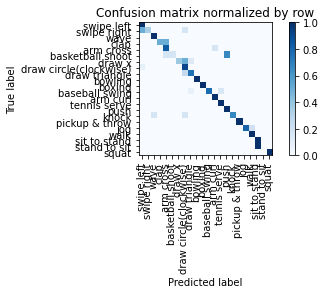

Overall accuracy: 0.819



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

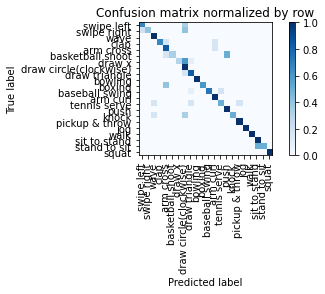

Overall accuracy: 0.806



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

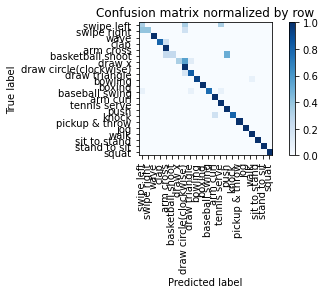

Overall accuracy: 0.869



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

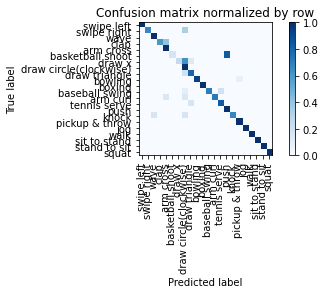

Overall accuracy: 0.850



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

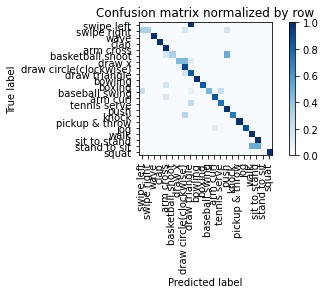

Overall accuracy: 0.806



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

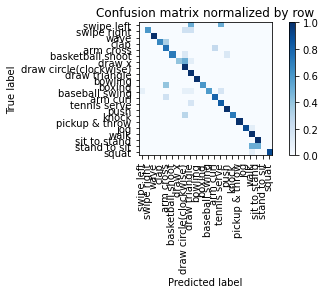

Overall accuracy: 0.812



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

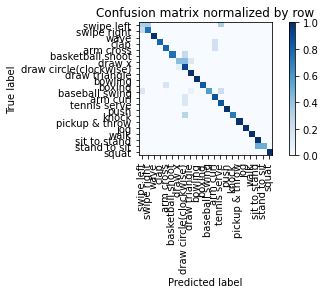

Overall accuracy: 0.856



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

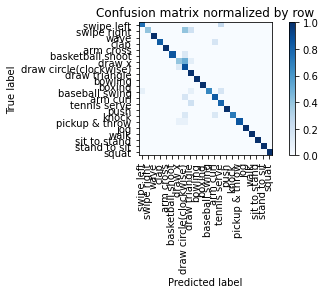

Overall accuracy: 0.856



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

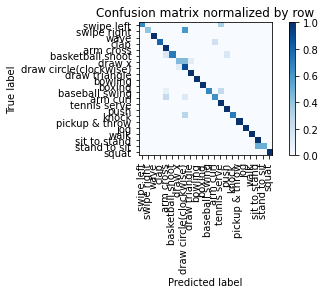

Overall accuracy: 0.856



train:   0%|          | 0/53 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

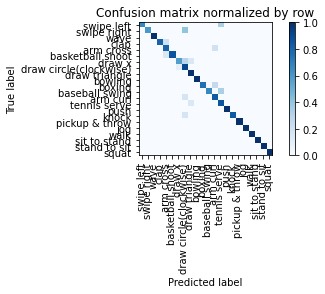

Overall accuracy: 0.894



unseen:   0%|          | 0/13 [00:00<?, ?batch/s]

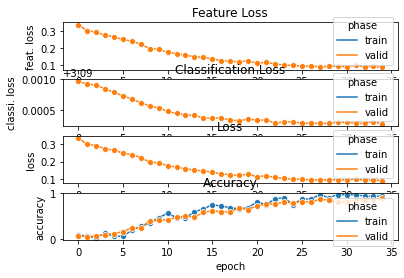

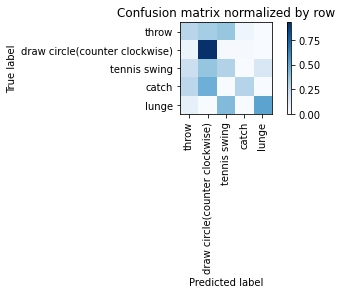

Overall accuracy: 0.507

{'accuracy': 0.5072115384615384, 'precision': 0.5442105628142361, 'recall': 0.4550902876190168, 'f1': 0.45390806932592087, 'samples': 416, 'loss': 121.11063575744629, 'feat. loss': 121.04372310638428, 'classi. loss': 669.118724822998}
============== Overall Unseen Classes Performance ==============


accuracy          0.326844
precision         0.284997
recall            0.295541
f1                0.246493
samples         448.000000
loss            155.356122
feat. loss      155.280198
classi. loss    759.239044
dtype: float64

In [ ]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=2, window_overlap=1.5, resample_freq=50,)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
